In [1]:
import pandas as pd
import numpy as np
import glob
import networkx as nx
import os
import matplotlib.pyplot as plt

In [2]:
def build_graphs(df):
    df = df[["timestamp", "pair", "close"]]
    df_pivot = df.pivot(index="timestamp", columns="pair", values="close")
    df_log = -np.log(df_pivot)

    graphs = {}
    for timestamp, row in df_log.iterrows():
        G = nx.DiGraph()
        for pair, weight in row.items():
            if pd.notna(weight):
                from_currency = pair[:3]
                to_currency = pair[3:]
                G.add_edge(from_currency, to_currency, weight=weight)
        graphs[timestamp] = G
    return graphs

C:\Users\avixa\AppData\Local\Temp\ipykernel_12140\561946597.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


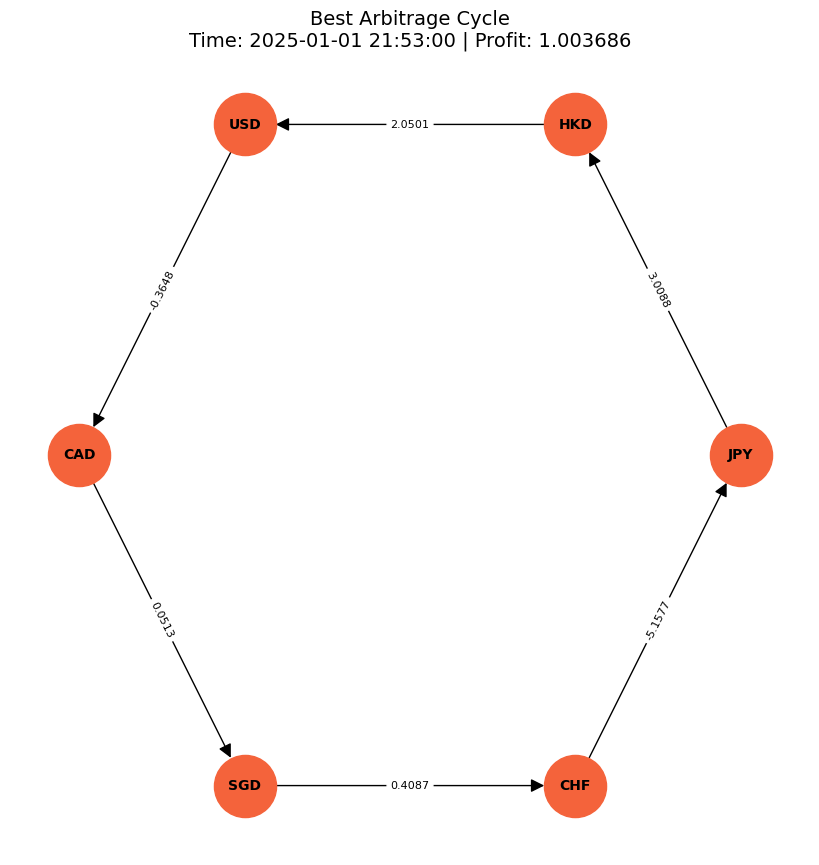

Best arbitrage cycle on 2025-01-01 at 2025-01-01 21:53:00
Profit multiplier: 1.003686
Cycle: JPY → HKD → USD → CAD → SGD → CHF → JPY


In [3]:
folder = "Arbitrage_Cycles"
best_cycle_info = None

for file in sorted(glob.glob(os.path.join(folder, "arbitrage_*.csv"))):
    df = pd.read_csv(file, parse_dates=["timestamp"])
    if df.empty:
        continue

    row = df.loc[df["profit_multiplier"].idxmax()]
    if best_cycle_info is None or row["profit_multiplier"] > best_cycle_info["profit_multiplier"]:
        best_cycle_info = row

cycle_str = best_cycle_info["cycle"]
profit = best_cycle_info["profit_multiplier"]
timestamp = pd.to_datetime(best_cycle_info["timestamp"])
date_str = str(best_cycle_info["date"])
cycle_nodes = cycle_str.split(" → ")
cycle_edges = list(zip(cycle_nodes, cycle_nodes[1:]))

data_file = f"./Data/forex_intraday_{date_str}.csv"
if not os.path.exists(data_file):
    raise FileNotFoundError(f"Data file for {date_str} not found: {data_file}")

df_day = pd.read_csv(data_file, parse_dates=["timestamp"])
graphs_for_day = build_graphs(df_day)

if timestamp not in graphs_for_day:
    raise KeyError(f"Timestamp {timestamp} not found in graphs for {date_str}.")

G_base = graphs_for_day[timestamp]

G_cycle = nx.DiGraph()
for u, v in cycle_edges:
    if G_base.has_edge(u, v):
        weight = G_base[u][v]["weight"]
        G_cycle.add_edge(u, v, weight=weight)

pos = nx.circular_layout(G_cycle)
edge_labels = nx.get_edge_attributes(G_cycle, "weight")
formatted_labels = {edge: f"{w:.4f}" for edge, w in edge_labels.items()}

plt.figure(figsize=(8, 8))
nx.draw(G_cycle, pos, with_labels=True, node_size=2000, node_color="#F4633B",
        font_size=10, font_weight='bold', arrows=True, arrowsize=20)
nx.draw_networkx_edge_labels(G_cycle, pos, edge_labels=formatted_labels, font_size=8)

plt.title(f"Best Arbitrage Cycle\nTime: {timestamp} | Profit: {profit:.6f}", size=14)
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join("Results", "best_overall_arbitrage_cycle.png"), dpi=300, bbox_inches='tight')
plt.show()

print(f"Best arbitrage cycle on {date_str} at {timestamp}")
print(f"Profit multiplier: {profit:.6f}")
print(f"Cycle: {cycle_str}")

C:\Users\avixa\AppData\Local\Temp\ipykernel_12140\2951689449.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


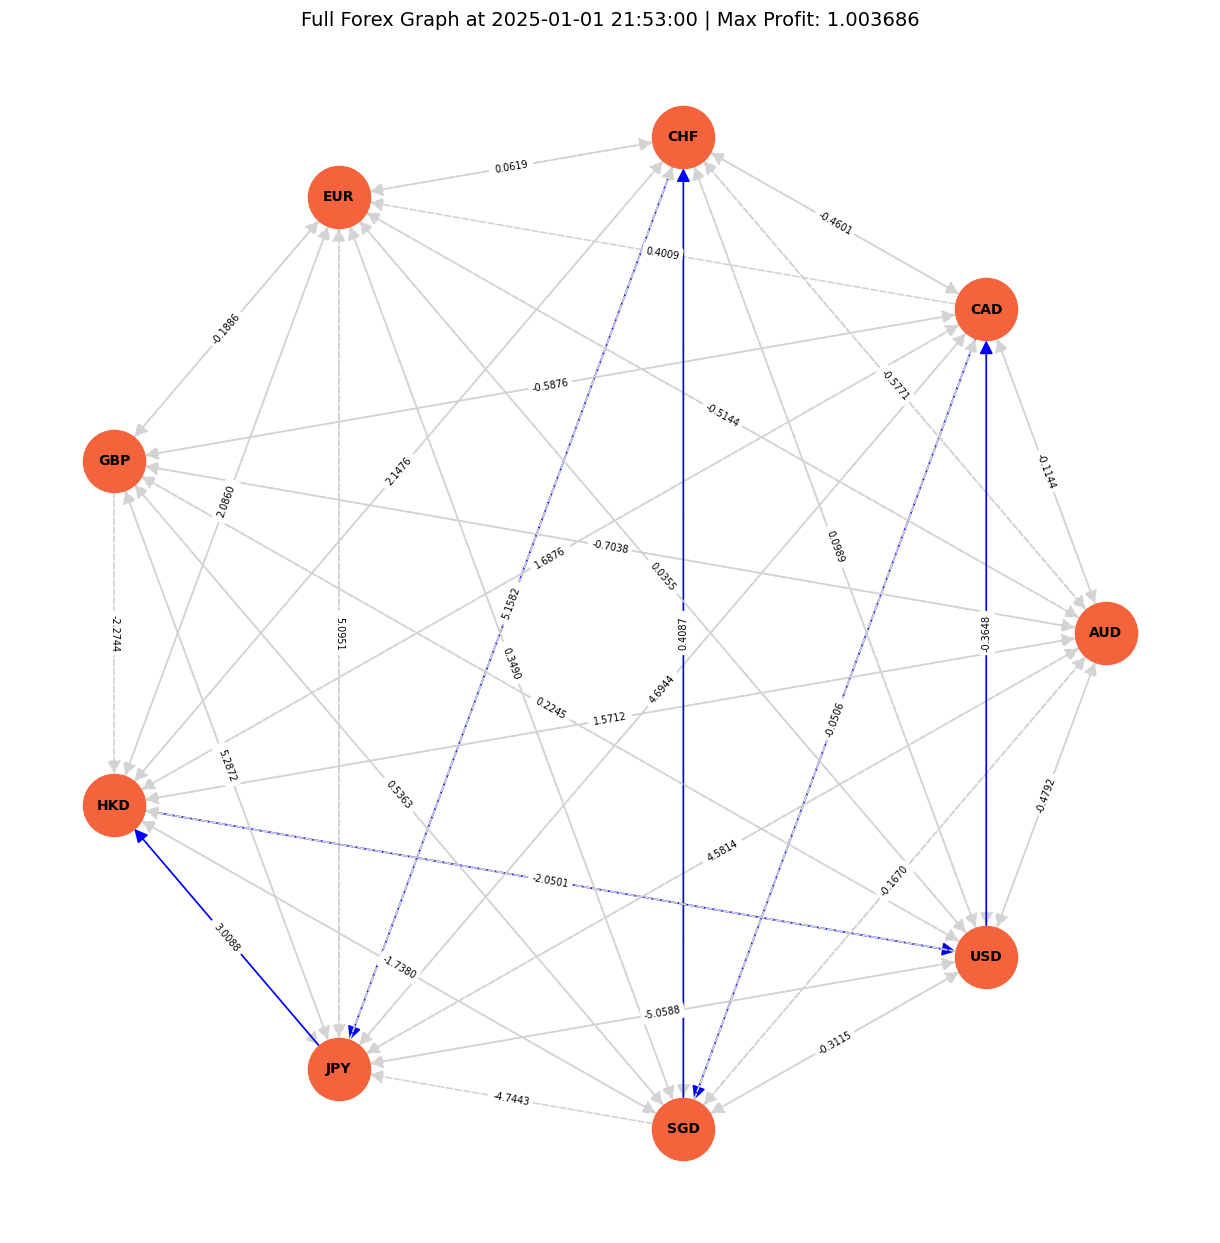

In [4]:
G_full = graphs_for_day[timestamp]

cycle_edge_set = set(cycle_edges)
edge_colors = []
for u, v in G_full.edges():
    if (u, v) in cycle_edge_set:
        edge_colors.append("blue")
    else:
        edge_colors.append("lightgray")

edge_styles = []
edge_widths = []
for u, v in G_full.edges():
    if (u, v) in cycle_edge_set:
        edge_styles.append("solid")
        edge_widths.append(4.5)
    else:
        edge_styles.append("dashed")
        edge_widths.append(0.6)

pos = nx.circular_layout(G_full)
edge_labels = nx.get_edge_attributes(G_full, "weight")
formatted_labels = {edge: f"{w:.4f}" for edge, w in edge_labels.items()}

# Plot
plt.figure(figsize=(12, 12))
nx.draw(G_full, pos,
        with_labels=True,
        node_size=2000,
        node_color="#F4633B",
        font_size=10,
        font_weight='bold',
        edge_color=edge_colors,
        style = edge_styles,
        width=1.2,
        arrows=True,
        arrowsize=20)

nx.draw_networkx_edge_labels(G_full, pos, edge_labels=formatted_labels, font_size=7)

plt.title(f"Full Forex Graph at {timestamp} | Max Profit: {profit:.6f}", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join("Results", "full_forex_graph_best_timestamp.png"), dpi=300)
plt.show()